In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import pyrtools as pt
import plenoptic as po
import scipy.io as sio
import os
import os.path as op
import glob
from tqdm import tqdm
from PIL import Image
directory = '/Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/'
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext heat

 
def ls(directory):
    return [os.path.join(directory, file) for file in glob.glob(f'{directory}*.jpg')]

torch.__version__
numpy = lambda x: x.detach().cpu().numpy().squeeze()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
n = 256
torch.set_default_dtype(torch.float64)       
im = po.load_images(directory+'DSCF9576.jpg') # 5DmkII_3874.jpg  10D_2988_2.jpg
m1 = im.mean().detach().numpy()-.05
m2 = im.mean().detach().numpy()+.05
initial_image = np.random.rand(n,n)*(m2-m1) + m1
model = po.simul.PortillaSimoncelli([n,n],n_scales=4, n_orientations=4, spatial_corr_width=9,use_true_correlations=True)       

met = po.synth.Metamer(im[0,0,:n,:n], model)

o=met.synthesize(learning_rate=.01,seed=1,
    loss_change_thresh=None,loss_change_iter=7,max_iter=10,coarse_to_fine='together',
    optimizer='Adam',initial_image = initial_image, store_progress=True)
# m=met.synthesize(learning_rate=.001,seed=1,
#     max_iter=1000,
#     optimizer='Adam',clamper=None,initial_image = m[0], store_progress=True)





/Users/kathrynbonnen/Documents/work-repos/plenoptic/plenoptic/simulate/canonical_computations/steerable_pyramid_freq.py:356: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370126481/work/aten/src/ATen/native/SpectralOps.cpp:590.)
  imdft = torch.rfft(x, signal_ndim=2, onesided=False, normalized=self.fft_normalize)
/Users/kathrynbonnen/Documents/work-repos/plenoptic/plenoptic/simulate/canonical_computations/steerable_pyramid_freq.py:363: UserWarning: The function torch.ifft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.ifftn. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370126481/wo

In [7]:
n = 256
torch.set_default_dtype(torch.float64)       
im = po.load_images(directory+'DSCF9576.jpg') # 5DmkII_3874.jpg  10D_2988_2.jpg
model = po.simul.PortillaSimoncelli([n,n],n_scales=4, n_orientations=4, spatial_corr_width=9,use_true_correlations=True)       

met = po.synth.Metamer(im[0,0,:n,:n], model)

o2=met.synthesize(learning_rate=.01,seed=1,
    loss_change_thresh=None,loss_change_iter=3,max_iter=20,coarse_to_fine='together',
    optimizer='Adam',initial_image = initial_image, store_progress=True)

100%|██████████| 10/10 [00:12<00:00,  1.20s/it, current_scale=residual_lowpass, current_scale_loss=11.8, gradient_norm=9.2990e-01, learning_rate=0.01, loss=1.0136e+01, pixel_change=1.0036e-02]


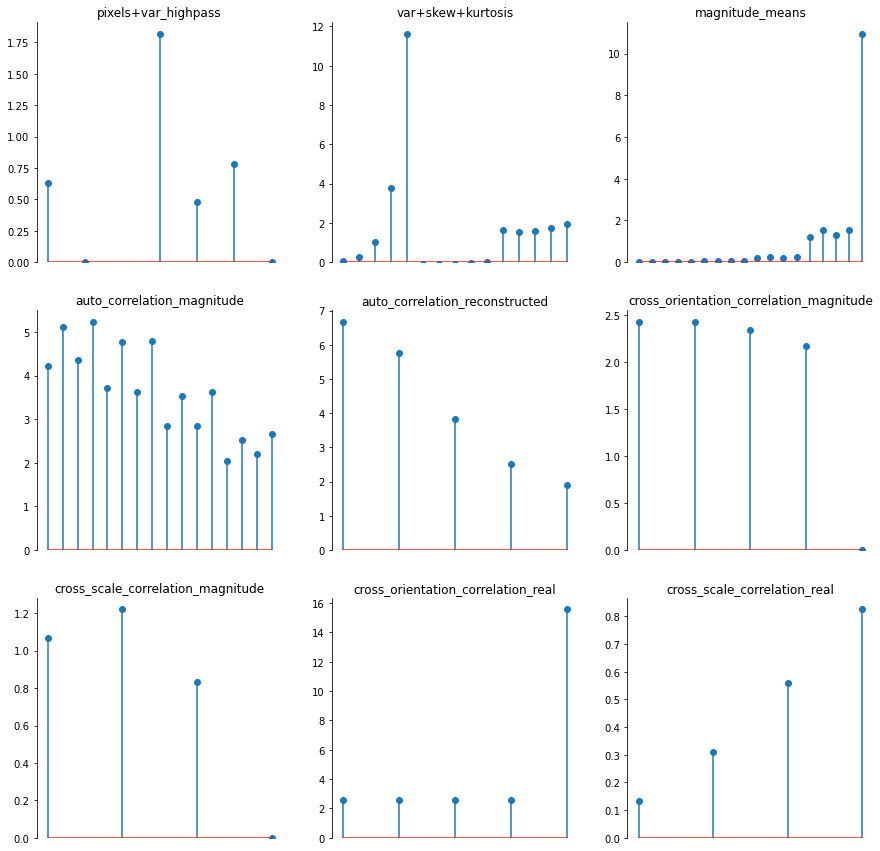

In [3]:
# np.max(np.abs(o[0].detach().numpy()-o2[0].detach().numpy()))


fig,axes = model.plot_representation()
# # model.update_plot(axes,0,model.representation)
# # met.plot_synthesis_status();
# # anim = met.animate()
# # po.convert_anim_to_html(anim)
# # # tmp.savefig('tmp.jpg')


In [57]:
with open('../data/portilla_simoncelli_synthesize.npy', 'rb') as f:
    a = np.load(f).squeeze()
    b = np.load(f).squeeze()

print(a.shape)


(256, 256)


In [25]:
# COMPARISON between models

# function to to load files
def load_images(files,n):
    ims = torch.zeros(len(files),1,n,n)
    
    for ii,f in enumerate(files):
        im = po.load_images(f)
        ims[ii,0,:,:] = im[0,0,:n,:n]
    return ims

def run_portilla_simoncelli(ims):
    n = ims.shape[3]
    y_python = torch.zeros(ims.shape[0],1,2461)
    model_python = po.simul.Portilla_Simoncelli([n,n],n_scales=4, n_orientations=4, spatial_corr_width=9,use_true_correlations=True)
    
    y_matlab = torch.zeros(ims.shape[0],1,2456)
    model_matlab = po.simul.Portilla_Simoncelli([n,n],n_scales=4, n_orientations=4, spatial_corr_width=9,use_true_correlations=False)

    for ii in tqdm(range(0,ims.shape[0])):
        y_python[ii,0,:] = model_python(ims[ii,0,:,:])
        y_matlab[ii,0,:] = model_matlab(ims[ii,0,:,:])
    
    return y_python, y_matlab

def compute_loss(y1,y2):
    
    return torch.norm(y1.squeeze()-y2.squeeze(),p=2,dim=1)/torch.norm(y2.squeeze(),p=2,dim=1)


In [8]:
# n = 256;
# # Load original images
# files = ls(directory)
# originals = load_images(files,n)

# # Load MATLAB images
# matlab_dir = '/Users/kathrynbonnen/Documents/ps-samples-256/matlab/'
# matlab_files = [glob.glob(matlab_dir + ff.split('/')[-1].split('.')[0] + '*')[0] for ff in files]
# matlab = load_images(matlab_files,n)

# # Load python images
# python_dir = '/Users/kathrynbonnen/Documents/ps-samples-256/python/'
# python_files = [glob.glob(python_dir + 'full_range' + ff.split('/')[-1].split('.')[0] + '*')[0] for ff in files]
# python = load_images(python_files,n)

# Load python low noise images
python_dir = '/Users/kathrynbonnen/Documents/ps-samples-256/python/'
python_files = [glob.glob(python_dir + 'low_noise_' + ff.split('/')[-1].split('.')[0] + '*')[0] for ff in files]
python_low = load_images(python_files,n)


In [10]:
# y_orig_python, y_orig_matlab = run_portilla_simoncelli(originals)
# y_mat_python, y_mat_matlab = run_portilla_simoncelli(matlab)
# y_py_python, y_py_matlab = run_portilla_simoncelli(python)
y_pyl_python, y_pyl_matlab = run_portilla_simoncelli(python_low)


100%|██████████| 787/787 [03:22<00:00,  3.88it/s]


In [11]:
mat_loss_python = compute_loss(y_mat_python,y_orig_python).detach()
mat_loss_matlab = compute_loss(y_mat_matlab,y_orig_matlab).detach()

# py_loss_python = compute_loss(y_py_python,y_orig_python).detach()
# py_loss_matlab = compute_loss(y_py_matlab,y_orig_matlab).detach()

pyl_loss_python = compute_loss(y_pyl_python,y_orig_python).detach()
pyl_loss_matlab = compute_loss(y_pyl_matlab,y_orig_matlab).detach()

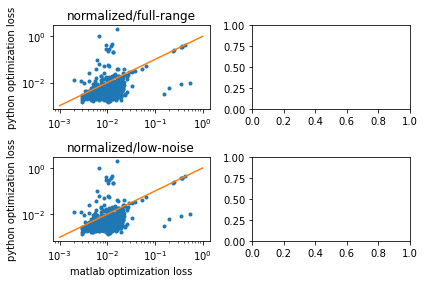

In [13]:
fig, ax = plt.subplots(2,2)
ref = [.001,1]
ax[0,0].plot(mat_loss_python,pyl_loss_python,'.')
ax[0,0].plot(ref,ref)
ax[0,0].set(yscale='log', xscale='log',ylabel='python optimization loss',
         title='normalized/full-range')

# ax[0,1].plot(mat_loss_matlab,py_loss_matlab,'.')
# ax[0,1].plot([10,10**4],[10,10**4])
# ax[0,1].set(yscale='log', xscale='log', title='un-normalized/full-range')

ax[1,0].plot(mat_loss_python,pyl_loss_python,'.')
ax[1,0].plot(ref,ref)
ax[1,0].set(yscale='log', xscale='log', xlabel='matlab optimization loss',
            ylabel='python optimization loss',title='normalized/low-noise')

# ax[1,1].plot(mat_loss_matlab,pyl_loss_matlab,'.')
# ax[1,1].plot([10,10**4],[10,10**4])
# ax[1,1].set(yscale='log', xscale='log', xlabel='matlab optimization loss',title='un-normalized/low-noise')
fig.tight_layout()
plt.show()

In [ ]:
print((mat_loss_python>py_loss_python).sum()/787,
(mat_loss_python>pyl_loss_python).sum()/787)

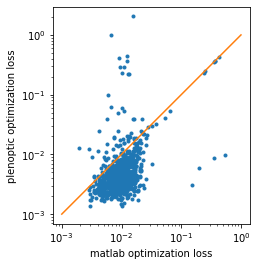

In [21]:
fig, ax = plt.subplots(1,1)
ax.plot(mat_loss_python,pyl_loss_python,'.')
ax.plot(ref,ref)
ax.set(yscale='log', xscale='log', xlabel='matlab optimization loss',
            ylabel='plenoptic optimization loss')
ax.set_aspect('equal', adjustable='box')

